In [2]:
# !pip install -q torchmetrics

In [3]:
# !git clone https://github.com/mamintoosi-papers-codes/TGCN-PyTorch.git
# %cd TGCN-PyTorch

In [1]:
%%time
pred_list = [1, 2, 3, 4]
for pre_len in pred_list:
    %run main.py --config configs/tgcn-los-pre_len{pre_len}.yaml --log_path train-tgcn-los-pre_len{pre_len}.log
    %run main.py --config configs/tgcn-los-gsl-pre_len{pre_len}.yaml --log_path train-tgcn-los-gsl-pre_len{pre_len}.log

[2025-02-27 16:22:48,296 INFO]Loaded config from configs/tgcn-los-pre_len1.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'losloop', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.TGCN', 'init_args': {'hidden_dim': 64, 'use_gsl': False}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse_with_regularizer'}}}
[2025-02-27 16:22:48,450 INFO]Using device: cuda
[2025-02-27 16:22:50,467 INFO]Starting training for 100 epochs...
[2025-02-27 16:22:51,843 INFO][Epoch 1/100] Train Loss: 1440.904708, Val Loss: 11408564.000000, RMSE: 16.790241, MAE: 13.608006, Accuracy: 0.7142, R2: 0.2206, Expl.Var: 0.4158
[2025-02-27 16:23:11,125 INFO][Epoch 21/100] Train Loss: 82.201613, Val Loss: 2644723.250000, RMSE: 8.084098, MAE: 5.698947, Accuracy: 0.8624, R2: 0.6595, Expl.Var: 0.6595
[2025-02-27 16:23:30,207 INFO][Epoch 41/100] Train Loss: 61.551160, Val Loss: 1976888.000000, RMSE: 6.989280, MAE: 4

CPU times: total: 11min 43s
Wall time: 12min 59s


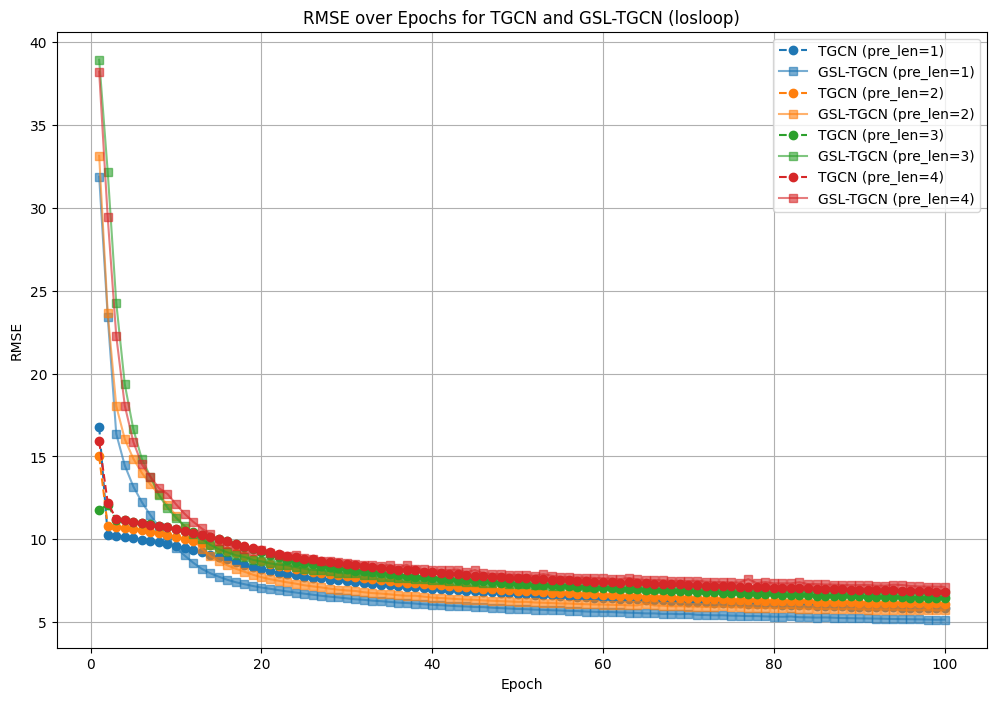

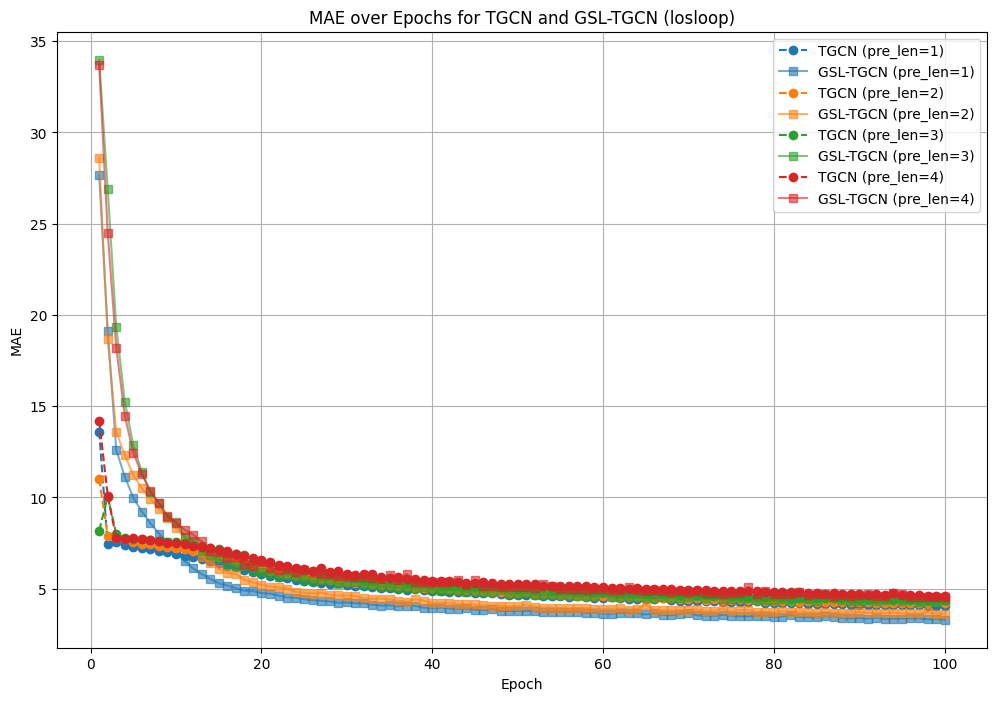

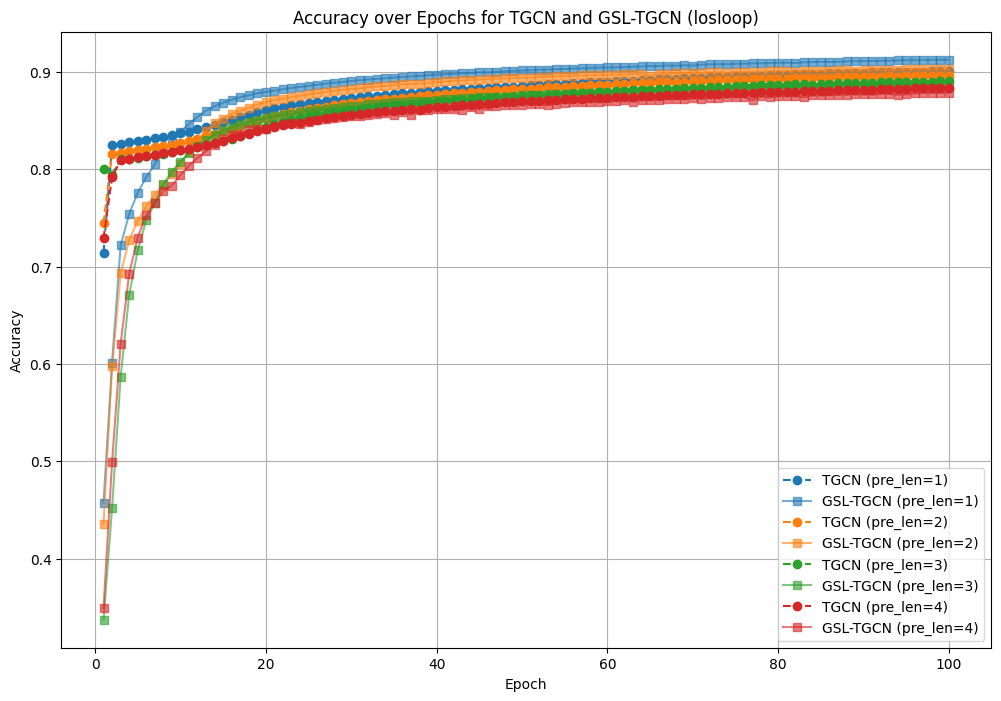

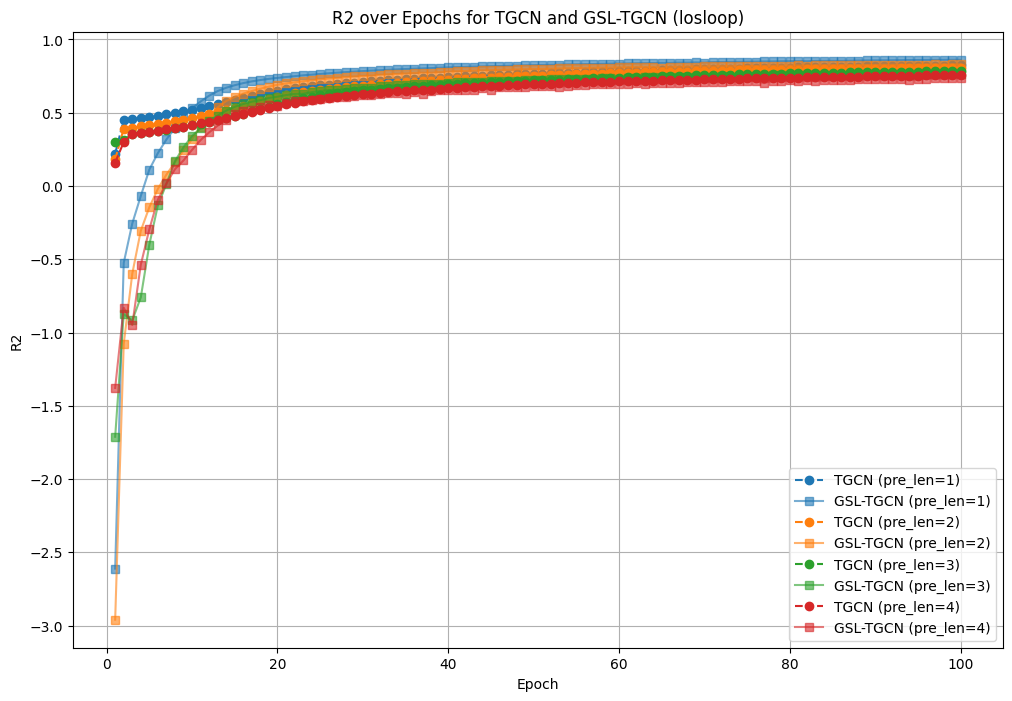

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the prediction lengths to loop through
pred_list = [1, 2, 3, 4]

# Define the measures to plot
measures = ["RMSE", "MAE", "Accuracy", "R2"]

# Define a color palette for each pre_len
colors = plt.cm.tab10.colors  # Using a predefined color palette (10 distinct colors)

# Loop through each measure
for measure in measures:
    # Create a new figure for each measure
    plt.figure(figsize=(12, 8))

    # Loop through each pre_len in pred_list
    for i, pre_len in enumerate(pred_list):
        # Generate the file paths dynamically based on pre_len
        metrics_file_gsl_false = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslFalse.csv"
        metrics_file_gsl_true = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslTrue.csv"

        # Load the metrics CSV files
        metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
        metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

        # Use the same base color for both methods, but with different intensity
        base_color = colors[i % len(colors)]  # Cycle through the color palette
        color_false = base_color  # Full intensity for GSL-false
        color_true = (*base_color[:3], 0.6)  # Reduced intensity (alpha = 0.6) for GSL-true

        # Plot the current measure for the current pre_len
        # Use dashed line for GSL-false (TGCN)
        plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false[measure], linestyle='--', marker='o', color=color_false, label=f"TGCN (pre_len={pre_len})")
        # Use solid line for GSL-true (GSL-TGCN)
        plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true[measure], linestyle='-', marker='s', color=color_true, label=f"GSL-TGCN (pre_len={pre_len})")

    # Add labels, title, legend, and grid
    plt.xlabel("Epoch")
    plt.ylabel(measure)
    plt.title(f"{measure} over Epochs for TGCN and GSL-TGCN (losloop)")
    plt.legend()
    plt.grid(True)

    # Show the plot for the current measure
    plt.show()

In [10]:
import pandas as pd

# Define the prediction lengths and measures
pred_list = [1, 2, 3, 4]
measures = ["RMSE", "MAE", "Accuracy", "R2"]

# Initialize a dictionary to store the results of the last epoch
results = {}

# Loop through each pre_len and measure to collect the last epoch results
for pre_len in pred_list:
    # Generate the file paths dynamically based on pre_len
    metrics_file_gsl_false = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslFalse.csv"
    metrics_file_gsl_true = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslTrue.csv"

    # Load the metrics CSV files
    metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
    metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

    # Get the last epoch results for both methods
    last_epoch_false = metrics_df_gsl_false.iloc[-1]  # Last row for GSL-false
    last_epoch_true = metrics_df_gsl_true.iloc[-1]    # Last row for GSL-true

    # Store the results in the dictionary
    results[f"TGCN (pre_len={pre_len})"] = last_epoch_false[measures]
    results[f"GSL-TGCN (pre_len={pre_len})"] = last_epoch_true[measures]

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results).T

# Function to highlight the winner for each pre_len and measure
def highlight_winner(df):
    highlighted_df = df.copy()
    for pre_len in pred_list:
        for measure in measures:
            # Get the values for the two methods for the current pre_len
            tgcn_value = df.loc[f"TGCN (pre_len={pre_len})", measure]
            gsl_tgcn_value = df.loc[f"GSL-TGCN (pre_len={pre_len})", measure]

            # Determine the winner based on the measure
            if measure in ["RMSE", "MAE"]:
                winner_value = min(tgcn_value, gsl_tgcn_value)  # Lower is better
            else:
                winner_value = max(tgcn_value, gsl_tgcn_value)  # Higher is better

            # Highlight the winner
            if tgcn_value == winner_value:
                highlighted_df.loc[f"TGCN (pre_len={pre_len})", measure] = f"\\textbf{{{tgcn_value:.4f}}}"
            else:
                highlighted_df.loc[f"TGCN (pre_len={pre_len})", measure] = f"{tgcn_value:.4f}"

            if gsl_tgcn_value == winner_value:
                highlighted_df.loc[f"GSL-TGCN (pre_len={pre_len})", measure] = f"\\textbf{{{gsl_tgcn_value:.4f}}}"
            else:
                highlighted_df.loc[f"GSL-TGCN (pre_len={pre_len})", measure] = f"{gsl_tgcn_value:.4f}"
    return highlighted_df

# Apply the highlight function to the results DataFrame
highlighted_results = highlight_winner(results_df)

# Generate the LaTeX table
latex_table = highlighted_results.to_latex(escape=False, column_format="l" + "c" * len(measures))

# Print the LaTeX table
print(latex_table)

\begin{tabular}{lcccc}
\toprule
{} &             RMSE &              MAE &         Accuracy &               R2 \\
\midrule
TGCN (pre_len=1)     &           5.8273 &           4.0535 &           0.9008 &           0.8230 \\
GSL-TGCN (pre_len=1) &  \textbf{5.1546} &  \textbf{3.2972} &  \textbf{0.9123} &  \textbf{0.8617} \\
TGCN (pre_len=2)     &           6.1016 &           4.2070 &           0.8961 &           0.8063 \\
GSL-TGCN (pre_len=2) &  \textbf{5.7189} &  \textbf{3.6292} &  \textbf{0.9027} &  \textbf{0.8300} \\
TGCN (pre_len=3)     &  \textbf{6.4529} &  \textbf{4.3506} &  \textbf{0.8901} &  \textbf{0.7837} \\
GSL-TGCN (pre_len=3) &           6.7089 &           4.3692 &           0.8858 &           0.7663 \\
TGCN (pre_len=4)     &  \textbf{6.8371} &           4.6140 &  \textbf{0.8836} &  \textbf{0.7573} \\
GSL-TGCN (pre_len=4) &           7.1315 &  \textbf{4.5409} &           0.8786 &           0.7360 \\
\bottomrule
\end{tabular}



In [12]:
import pandas as pd

# Define the prediction lengths and measures
pred_list = [1, 2, 3, 4]
measures = ["RMSE", "MAE", "Accuracy", "R2"]

# Initialize a dictionary to store the first epoch where GSL-true is better
first_epoch_better = {f"pre_len={pre_len}": {measure: None for measure in measures} for pre_len in pred_list}

# Loop through each pre_len and measure to find the first epoch where GSL-true is better
for pre_len in pred_list:
    # Generate the file paths dynamically based on pre_len
    metrics_file_gsl_false = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslFalse.csv"
    metrics_file_gsl_true = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslTrue.csv"

    # Load the metrics CSV files
    metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
    metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

    # Loop through each measure
    for measure in measures:
        # Initialize a flag to track if GSL-true has become better
        better_epoch = None

        # Loop through each epoch
        for epoch in range(len(metrics_df_gsl_false)):
            tgcn_value = metrics_df_gsl_false.loc[epoch, measure]
            gsl_tgcn_value = metrics_df_gsl_true.loc[epoch, measure]

            # Check if GSL-true is better than TGCN
            if measure in ["RMSE", "MAE"]:
                if gsl_tgcn_value < tgcn_value:  # Lower is better
                    better_epoch = epoch + 1  # Epochs are 1-indexed
                    break
            else:
                if gsl_tgcn_value > tgcn_value:  # Higher is better
                    better_epoch = epoch + 1
                    break

        # Store the result
        first_epoch_better[f"pre_len={pre_len}"][measure] = better_epoch if better_epoch is not None else "-"

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(first_epoch_better).T

# Generate the LaTeX table
latex_table = results_df.to_latex(escape=False, column_format="l" + "c" * len(measures))

# Print the LaTeX table
print(latex_table)

\begin{tabular}{lcccc}
\toprule
{} &  RMSE &  MAE &  Accuracy &  R2 \\
\midrule
pre_len=1 &    10 &   11 &        10 &  10 \\
pre_len=2 &    13 &   13 &        13 &  13 \\
pre_len=3 &    12 &   13 &        12 &  12 \\
pre_len=4 &    15 &   14 &        15 &  15 \\
\bottomrule
\end{tabular}



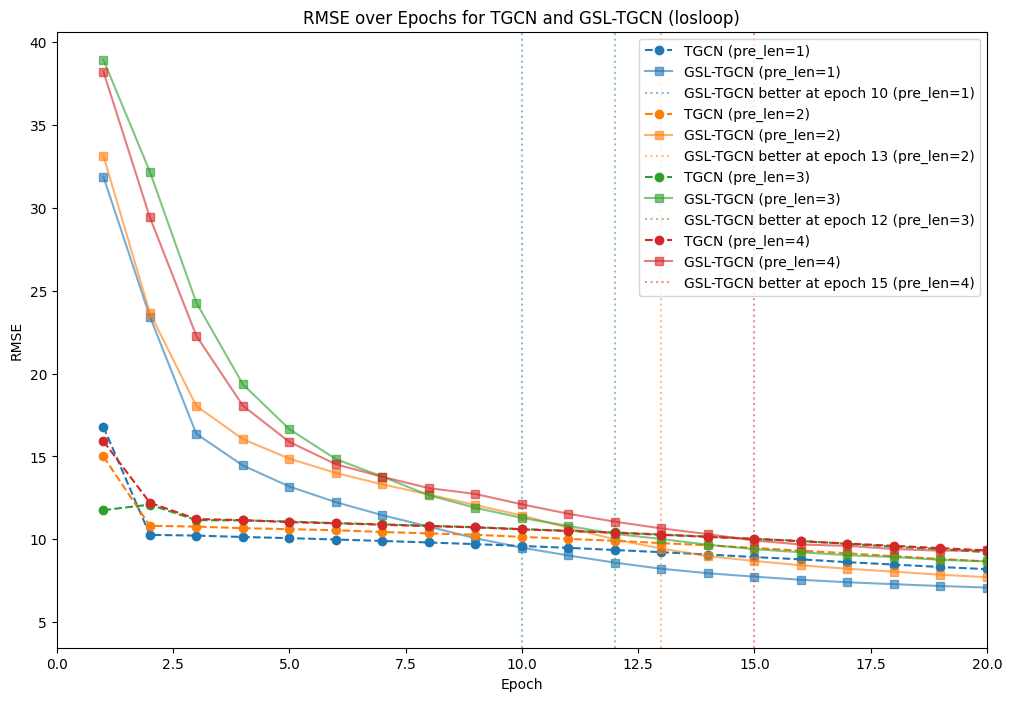

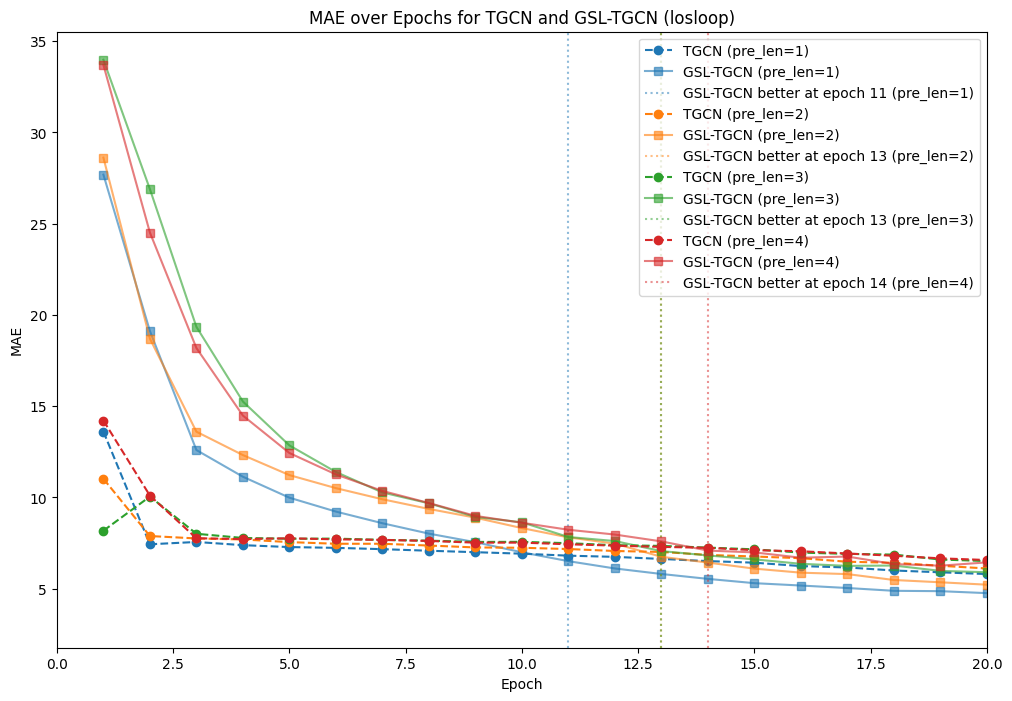

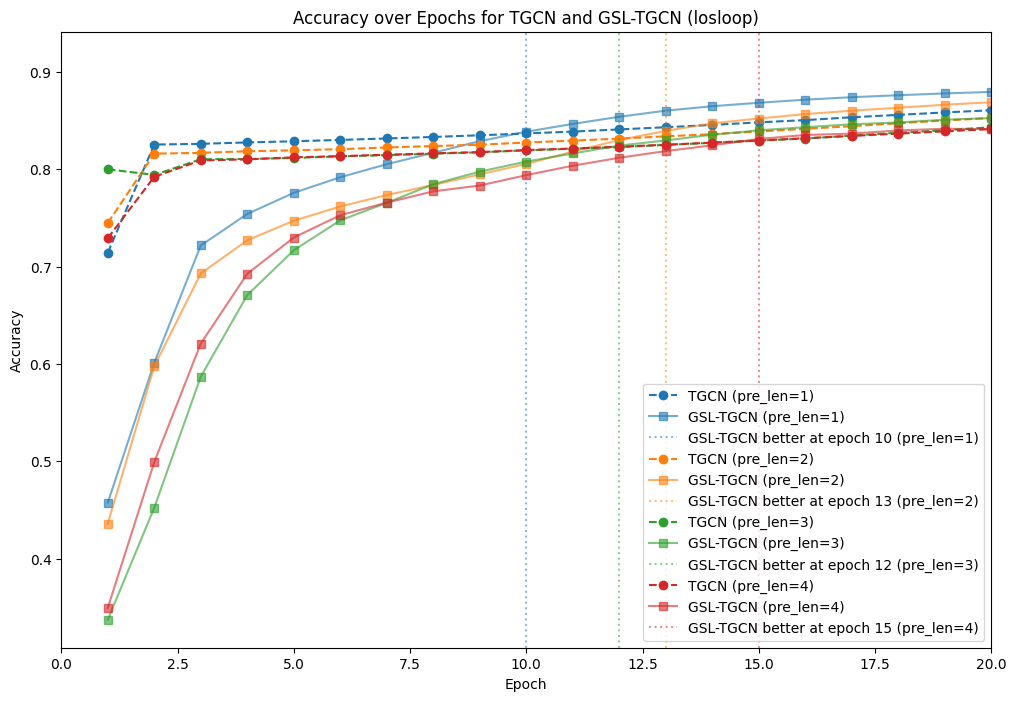

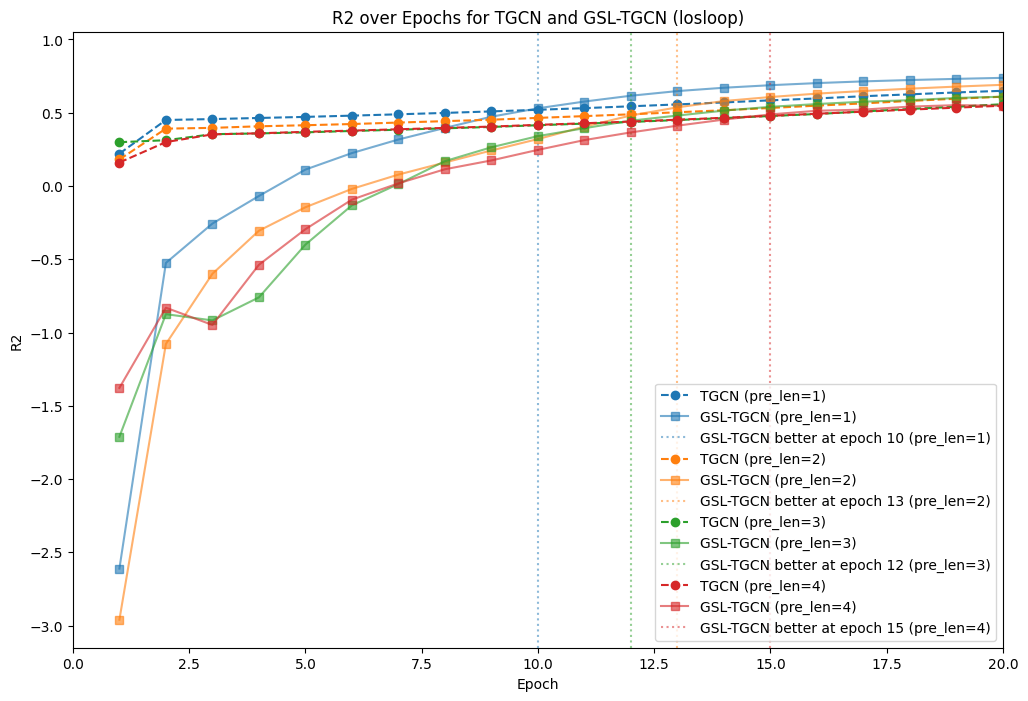

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the prediction lengths and measures
pred_list = [1, 2, 3, 4]
measures = ["RMSE", "MAE", "Accuracy", "R2"]

# Define a color palette for each pre_len
colors = plt.cm.tab10.colors  # Using a predefined color palette (10 distinct colors)

# Loop through each measure
for measure in measures:
    # Create a new figure for each measure
    plt.figure(figsize=(12, 8))

    # Loop through each pre_len in pred_list
    for i, pre_len in enumerate(pred_list):
        # Generate the file paths dynamically based on pre_len
        metrics_file_gsl_false = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslFalse.csv"
        metrics_file_gsl_true = f"results/metrics_losloop_TGCN_seq12_pre{pre_len}_gslTrue.csv"

        # Load the metrics CSV files
        metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
        metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

        # Use the same base color for both methods, but with different intensity
        base_color = colors[i % len(colors)]  # Cycle through the color palette
        color_false = base_color  # Full intensity for GSL-false
        color_true = (*base_color[:3], 0.6)  # Reduced intensity (alpha = 0.6) for GSL-true

        # Plot the current measure for the current pre_len
        # Use dashed line for GSL-false (TGCN)
        plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false[measure], linestyle='--', marker='o', color=color_false, label=f"TGCN (pre_len={pre_len})")
        # Use solid line for GSL-true (GSL-TGCN)
        plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true[measure], linestyle='-', marker='s', color=color_true, label=f"GSL-TGCN (pre_len={pre_len})")

        # Find the first epoch where GSL-true is better than GSL-false
        better_epoch = None
        for epoch in range(len(metrics_df_gsl_false)):
            tgcn_value = metrics_df_gsl_false.loc[epoch, measure]
            gsl_tgcn_value = metrics_df_gsl_true.loc[epoch, measure]

            # Check if GSL-true is better than TGCN
            if measure in ["RMSE", "MAE"]:
                if gsl_tgcn_value < tgcn_value:  # Lower is better
                    better_epoch = epoch + 1  # Epochs are 1-indexed
                    break
            else:
                if gsl_tgcn_value > tgcn_value:  # Higher is better
                    better_epoch = epoch + 1
                    break

        # Highlight the first epoch where GSL-true is better
        if better_epoch is not None and better_epoch <= 20:
            plt.axvline(x=better_epoch, color=color_true, linestyle=':', alpha=0.5, label=f"GSL-TGCN better at epoch {better_epoch} (pre_len={pre_len})")

    # Add labels, title, legend, and grid
    plt.xlabel("Epoch")
    plt.ylabel(measure)
    plt.title(f"{measure} over Epochs for TGCN and GSL-TGCN (losloop)")
    plt.legend()
    # plt.grid(True)

    # Limit the x-axis to the first 30 epochs
    plt.xlim(0, 20)

    # Show the plot for the current measure
    plt.show()

In [2]:
%%time
pred_list = [1, 2, 3, 4]
for pre_len in pred_list:
    %run main.py --config configs/tgcn-sz-pre_len{pre_len}.yaml --log_path train-tgcn-sz-pre_len{pre_len}.log
    %run main.py --config configs/tgcn-sz-gsl-pre_len{pre_len}.yaml --log_path train-tgcn-sz-gsl-pre_len{pre_len}.log

[2025-02-27 19:23:57,053 INFO]Loaded config from configs/tgcn-sz-pre_len1.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'shenzhen', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.TGCN', 'init_args': {'hidden_dim': 100, 'use_gsl': False}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse_with_regularizer'}}}
[2025-02-27 19:23:57,214 INFO]Using device: cuda
[2025-02-27 19:23:57,219 INFO]Starting training for 100 epochs...
[2025-02-27 19:23:59,053 INFO][Epoch 1/100] Train Loss: 79.689592, Val Loss: 1798669.750000, RMSE: 6.289181, MAE: 4.965939, Accuracy: 0.5618, R2: 0.6444, Expl.Var: 0.6569
[2025-02-27 19:24:30,357 INFO][Epoch 21/100] Train Loss: 34.637933, Val Loss: 1401603.625000, RMSE: 5.551764, MAE: 4.109559, Accuracy: 0.6132, R2: 0.7175, Expl.Var: 0.7175
[2025-02-27 19:25:01,189 INFO][Epoch 41/100] Train Loss: 26.753417, Val Loss: 1015605.875000, RMSE: 4.725861, MAE: 3.436

CPU times: total: 17min 30s
Wall time: 20min


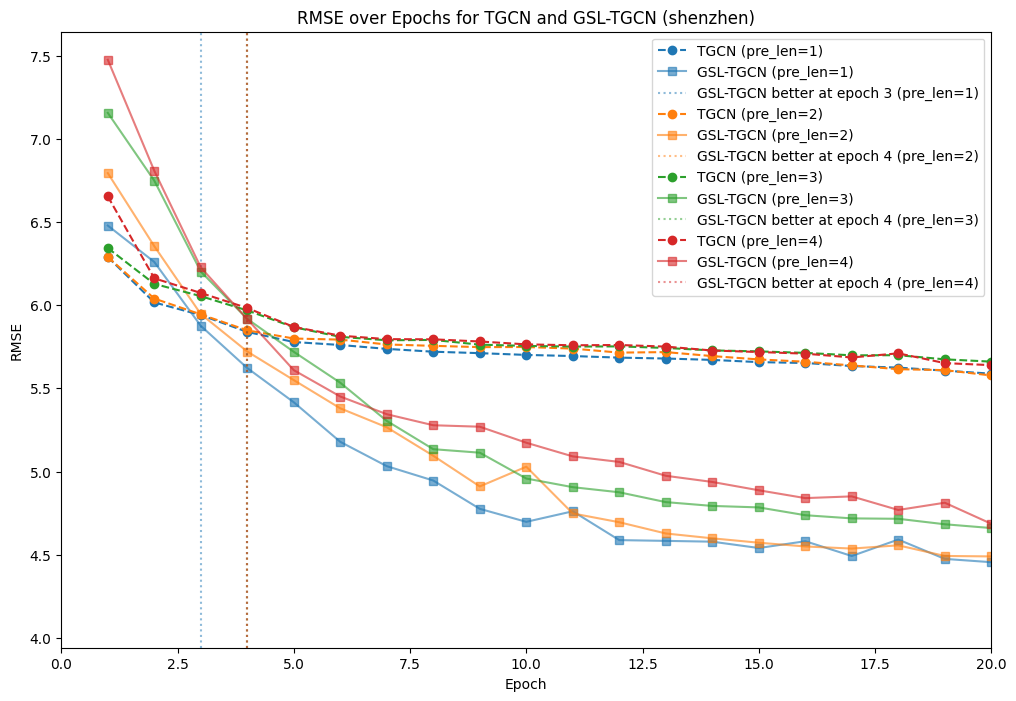

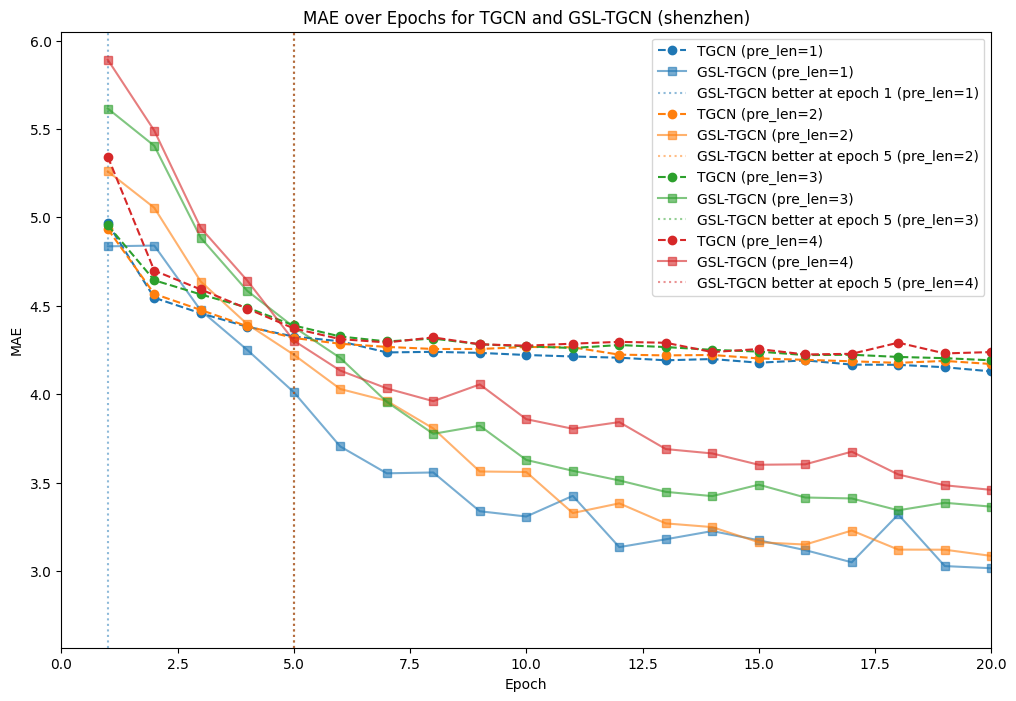

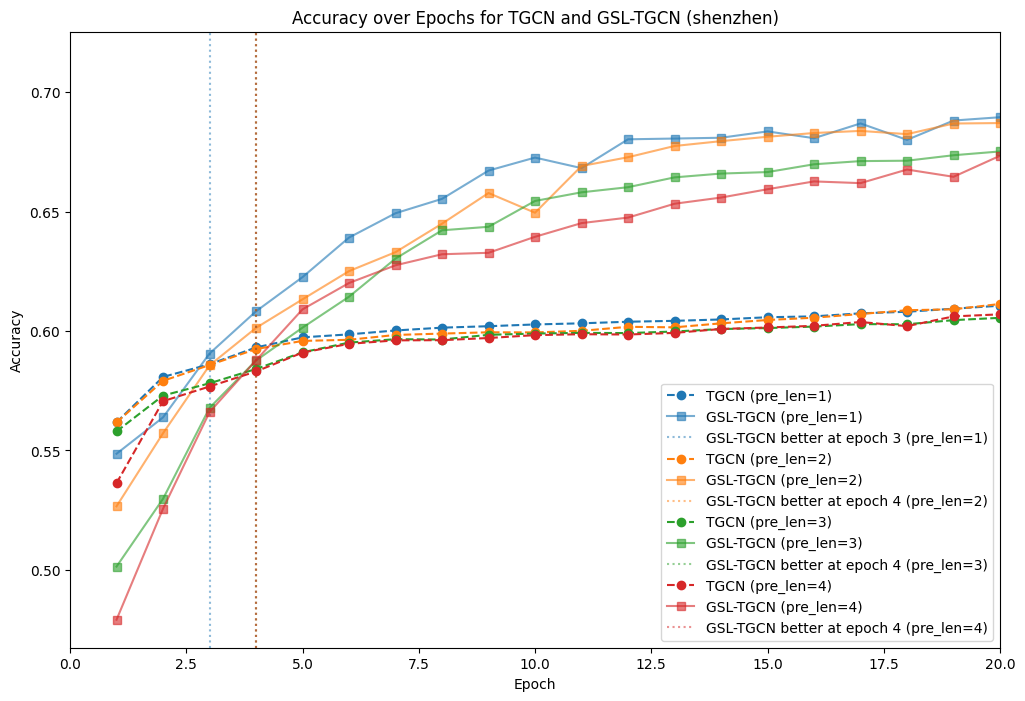

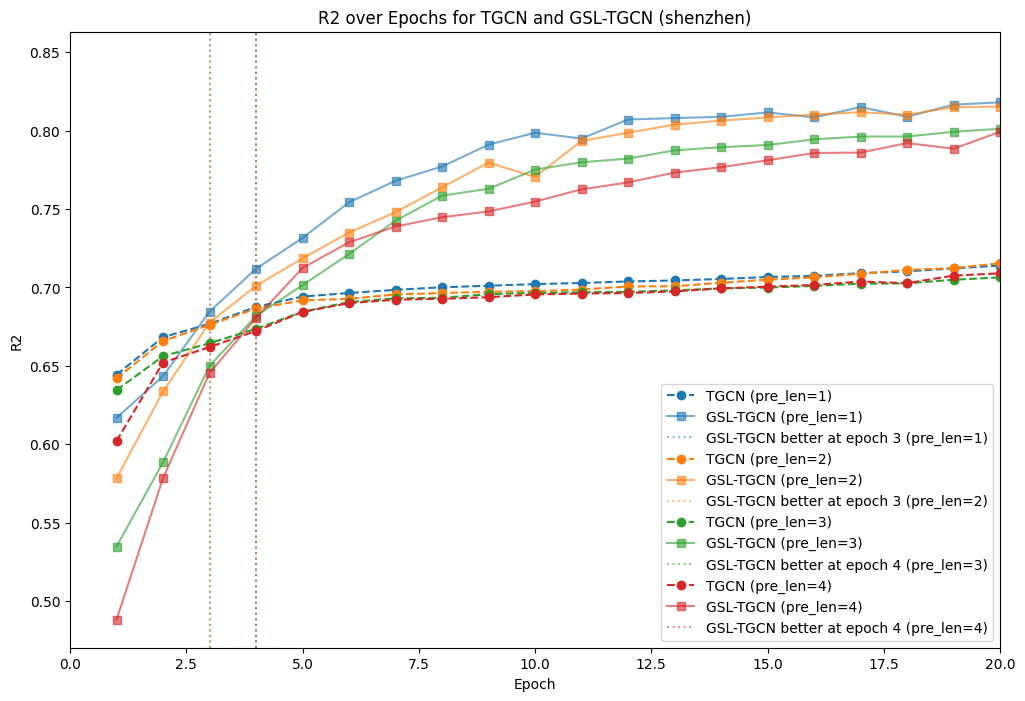

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the prediction lengths and measures
pred_list = [1, 2, 3, 4]
measures = ["RMSE", "MAE", "Accuracy", "R2"]

# Define a color palette for each pre_len
colors = plt.cm.tab10.colors  # Using a predefined color palette (10 distinct colors)

# Loop through each measure
for measure in measures:
    # Create a new figure for each measure
    plt.figure(figsize=(12, 8))

    # Loop through each pre_len in pred_list
    for i, pre_len in enumerate(pred_list):
        # Generate the file paths dynamically based on pre_len
        metrics_file_gsl_false = f"results/metrics_shenzhen_TGCN_seq12_pre{pre_len}_gslFalse.csv"
        metrics_file_gsl_true = f"results/metrics_shenzhen_TGCN_seq12_pre{pre_len}_gslTrue.csv"

        # Load the metrics CSV files
        metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
        metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

        # Use the same base color for both methods, but with different intensity
        base_color = colors[i % len(colors)]  # Cycle through the color palette
        color_false = base_color  # Full intensity for GSL-false
        color_true = (*base_color[:3], 0.6)  # Reduced intensity (alpha = 0.6) for GSL-true

        # Plot the current measure for the current pre_len
        # Use dashed line for GSL-false (TGCN)
        plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false[measure], linestyle='--', marker='o', color=color_false, label=f"TGCN (pre_len={pre_len})")
        # Use solid line for GSL-true (GSL-TGCN)
        plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true[measure], linestyle='-', marker='s', color=color_true, label=f"GSL-TGCN (pre_len={pre_len})")

        # Find the first epoch where GSL-true is better than GSL-false
        better_epoch = None
        for epoch in range(len(metrics_df_gsl_false)):
            tgcn_value = metrics_df_gsl_false.loc[epoch, measure]
            gsl_tgcn_value = metrics_df_gsl_true.loc[epoch, measure]

            # Check if GSL-true is better than TGCN
            if measure in ["RMSE", "MAE"]:
                if gsl_tgcn_value < tgcn_value:  # Lower is better
                    better_epoch = epoch + 1  # Epochs are 1-indexed
                    break
            else:
                if gsl_tgcn_value > tgcn_value:  # Higher is better
                    better_epoch = epoch + 1
                    break

        # Highlight the first epoch where GSL-true is better
        if better_epoch is not None and better_epoch <= 20:
            plt.axvline(x=better_epoch, color=color_true, linestyle=':', alpha=0.5, label=f"GSL-TGCN better at epoch {better_epoch} (pre_len={pre_len})")

    # Add labels, title, legend, and grid
    plt.xlabel("Epoch")
    plt.ylabel(measure)
    plt.title(f"{measure} over Epochs for TGCN and GSL-TGCN (shenzhen)")
    plt.legend()
    # plt.grid(True)

    # Limit the x-axis to the first 30 epochs
    plt.xlim(0, 20)

    # Show the plot for the current measure
    plt.show()

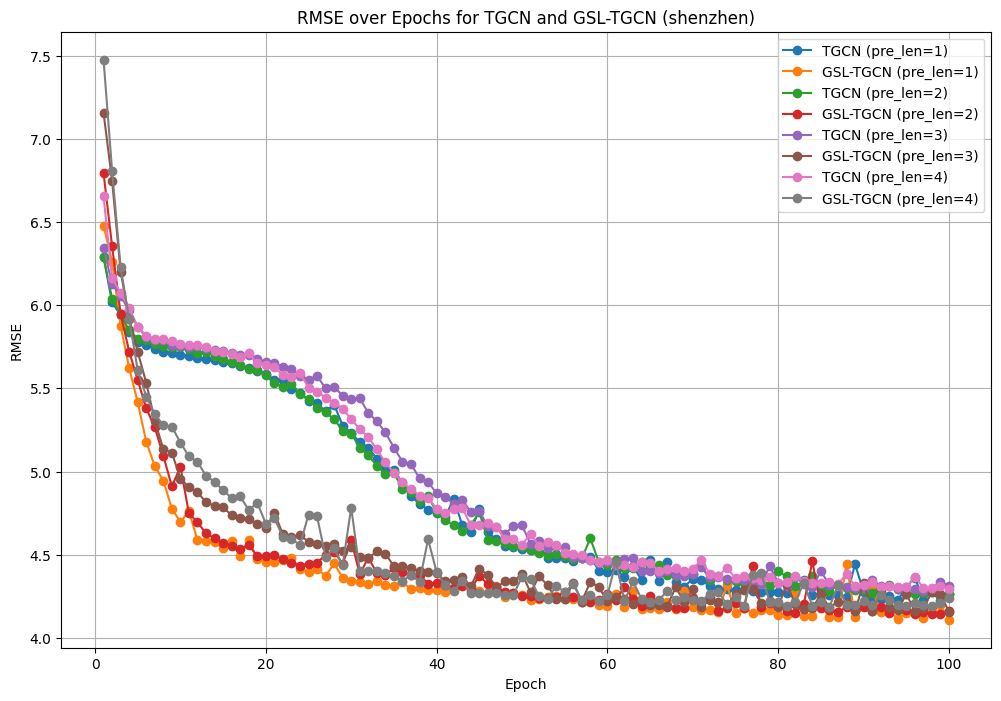

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the prediction lengths to loop through
pred_list = [1, 2, 3, 4]

# Create a figure to hold all the plots
plt.figure(figsize=(12, 8))

# Loop through each pre_len in pred_list
for pre_len in pred_list:
    # Generate the file paths dynamically based on pre_len
    metrics_file_gsl_false = f"results/metrics_shenzhen_TGCN_seq12_pre{pre_len}_gslFalse.csv"
    metrics_file_gsl_true = f"results/metrics_shenzhen_TGCN_seq12_pre{pre_len}_gslTrue.csv"

    # Load the metrics CSV files
    metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
    metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

    # Plot RMSE values for the current pre_len
    plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false["RMSE"], marker='o', label=f"TGCN (pre_len={pre_len})")
    plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true["RMSE"], marker='o', label=f"GSL-TGCN (pre_len={pre_len})")

# Add labels, title, legend, and grid
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs for TGCN and GSL-TGCN (shenzhen)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [4]:
%%time
%run main.py --config configs/gcn-los.yaml --log_path train-gcn-los.log

[2025-02-27 11:34:07,411 INFO]Loaded config from configs/gcn-los.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'losloop', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.GCN', 'init_args': {'hidden_dim': 100, 'use_gsl': False}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse'}}}


[2025-02-27 11:34:07,515 INFO]Using device: cuda
[2025-02-27 11:34:07,529 INFO]Starting training for 100 epochs...
[2025-02-27 11:34:07,750 INFO][Epoch 1/100] Train Loss: 0.275240, Val Loss: 332.252045, RMSE: 18.227781, MAE: 16.029799, Accuracy: 0.6898, R2: 0.2511, Expl.Var: 0.5805
[2025-02-27 11:34:09,550 INFO][Epoch 21/100] Train Loss: 0.013230, Val Loss: 71.257286, RMSE: 8.441403, MAE: 5.939933, Accuracy: 0.8563, R2: 0.6293, Expl.Var: 0.6303
[2025-02-27 11:34:11,235 INFO][Epoch 41/100] Train Loss: 0.012101, Val Loss: 63.594044, RMSE: 7.974587, MAE: 5.734778, Accuracy: 0.8643, R2: 0.6688, Expl.Var: 0.6692
[2025-02-27 11:34:12,917 INFO][Epoch 61/100] Train Loss: 0.011814, Val Loss: 61.750069, RMSE: 7.858121, MAE: 5.677486, Accuracy: 0.8663, R2: 0.6784, Expl.Var: 0.6789
[2025-02-27 11:34:14,649 INFO][Epoch 81/100] Train Loss: 0.011658, Val Loss: 60.728359, RMSE: 7.792840, MAE: 5.657836, Accuracy: 0.8674, R2: 0.6836, Expl.Var: 0.6836
[2025-02-27 11:34:16,489 INFO][Epoch 100/100] Train L

CPU times: total: 8.89 s
Wall time: 9.1 s


Losloop

In [5]:
%%time
%run main.py --config configs/gcn-los-gsl.yaml --log_path train-gcn-los-gsl.log

[2025-02-27 11:34:16,553 INFO]Loaded config from configs/gcn-los-gsl.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'losloop', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.GCN', 'init_args': {'hidden_dim': 100, 'use_gsl': True}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse'}}}
[2025-02-27 11:34:16,659 INFO]Using device: cuda
[2025-02-27 11:34:16,674 INFO]Starting training for 100 epochs...
[2025-02-27 11:34:16,772 INFO][Epoch 1/100] Train Loss: 0.375332, Val Loss: 644.510010, RMSE: 25.387201, MAE: 21.087177, Accuracy: 0.5679, R2: -0.9657, Expl.Var: -1.6501
[2025-02-27 11:34:18,521 INFO][Epoch 21/100] Train Loss: 0.030254, Val Loss: 176.736877, RMSE: 13.294242, MAE: 9.195404, Accuracy: 0.7737, R2: 0.0820, Expl.Var: 0.0823
[2025-02-27 11:34:20,201 INFO][Epoch 41/100] Train Loss: 0.026857, Val Loss: 163.404892, RMSE: 12.782992, MAE: 8.859798, Accuracy: 0.7824, R2: 0.1591,

CPU times: total: 8.8 s
Wall time: 9.08 s


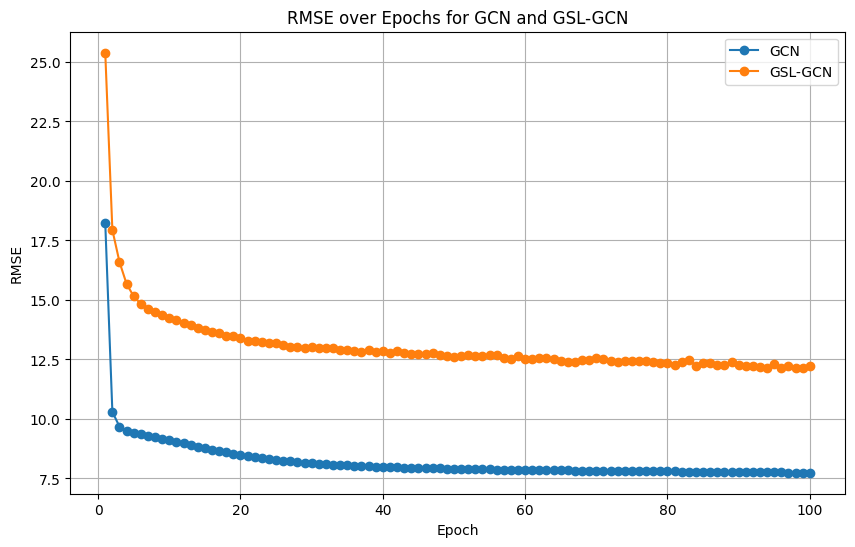

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics CSV files
metrics_file_gsl_false = "results/metrics_losloop_GCN_seq12_pre1_gslFalse.csv"
metrics_file_gsl_true = "results/metrics_losloop_GCN_seq12_pre1_gslTrue.csv"

metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

# Plot RMSE values
plt.figure(figsize=(10, 6))
plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false["RMSE"], marker='o', label="GCN")
plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true["RMSE"], marker='o', label="GSL-GCN")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs for GCN and GSL-GCN")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
%%time
%run main.py --config configs/gcn-sz.yaml --log_path train-gcn-sz.log

[2025-02-27 11:35:26,552 INFO]Loaded config from configs/gcn-sz.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'shenzhen', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.GCN', 'init_args': {'hidden_dim': 100, 'use_gsl': False}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse'}}}
[2025-02-27 11:35:26,690 INFO]Using device: cuda
[2025-02-27 11:35:26,693 INFO]Starting training for 100 epochs...
[2025-02-27 11:35:26,919 INFO][Epoch 1/100] Train Loss: 0.012916, Val Loss: 46.227516, RMSE: 6.799082, MAE: 5.633923, Accuracy: 0.5263, R2: 0.5919, Expl.Var: 0.6144
[2025-02-27 11:35:29,366 INFO][Epoch 21/100] Train Loss: 0.007874, Val Loss: 35.520493, RMSE: 5.959907, MAE: 4.413796, Accuracy: 0.5847, R2: 0.6745, Expl.Var: 0.6746
[2025-02-27 11:35:31,978 INFO][Epoch 41/100] Train Loss: 0.007871, Val Loss: 35.509102, RMSE: 5.958951, MAE: 4.409276, Accuracy: 0.5848, R2: 0.6746, Expl.Var: 0

CPU times: total: 12.3 s
Wall time: 12.9 s


In [7]:
%%time
%run main.py --config configs/gcn-sz-gsl.yaml --log_path train-gcn-sz-gsl.log

[2025-02-27 11:34:26,020 INFO]Loaded config from configs/gcn-sz-gsl.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'shenzhen', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.GCN', 'init_args': {'hidden_dim': 100, 'use_gsl': True}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse'}}}
[2025-02-27 11:34:26,205 INFO]Using device: cuda
[2025-02-27 11:34:26,208 INFO]Starting training for 100 epochs...
[2025-02-27 11:34:26,422 INFO][Epoch 1/100] Train Loss: 0.022597, Val Loss: 51.418388, RMSE: 7.170661, MAE: 5.772279, Accuracy: 0.5004, R2: 0.5328, Expl.Var: 0.5374
[2025-02-27 11:34:29,243 INFO][Epoch 21/100] Train Loss: 0.010778, Val Loss: 43.139488, RMSE: 6.568066, MAE: 4.961005, Accuracy: 0.5424, R2: 0.6075, Expl.Var: 0.6120
[2025-02-27 11:34:31,890 INFO][Epoch 41/100] Train Loss: 0.010475, Val Loss: 41.701168, RMSE: 6.457644, MAE: 4.615288, Accuracy: 0.5500, R2: 0.6206, Expl.Var

CPU times: total: 12.1 s
Wall time: 13.2 s


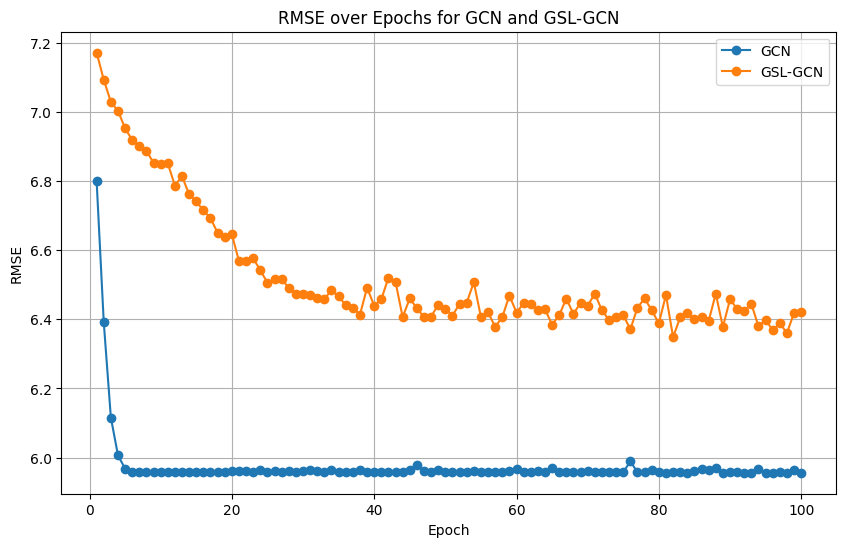

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics CSV files
metrics_file_gsl_false = "results/metrics_shenzhen_GCN_seq12_pre1_gslFalse.csv"
metrics_file_gsl_true = "results/metrics_shenzhen_GCN_seq12_pre1_gslTrue.csv"

metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

# Plot RMSE values
plt.figure(figsize=(10, 6))
plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false["RMSE"], marker='o', label="GCN")
plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true["RMSE"], marker='o', label="GSL-GCN")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs for GCN and GSL-GCN")
plt.legend()
plt.grid(True)
plt.show()

SZ

In [11]:
%%time
%run main.py --config configs/tgcn-sz.yaml --log_path train-tgcn-sz.log

[2025-02-27 11:35:45,615 INFO]Loaded config from configs/tgcn-sz.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'shenzhen', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.TGCN', 'init_args': {'hidden_dim': 100, 'use_gsl': False}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse_with_regularizer'}}}
[2025-02-27 11:35:45,750 INFO]Using device: cuda
[2025-02-27 11:35:45,757 INFO]Starting training for 100 epochs...
[2025-02-27 11:35:47,582 INFO][Epoch 1/100] Train Loss: 86.805042, Val Loss: 1827752.750000, RMSE: 6.339823, MAE: 5.074636, Accuracy: 0.5583, R2: 0.6373, Expl.Var: 0.6472
[2025-02-27 11:36:16,865 INFO][Epoch 21/100] Train Loss: 35.164931, Val Loss: 1432493.625000, RMSE: 5.612608, MAE: 4.152684, Accuracy: 0.6089, R2: 0.7114, Expl.Var: 0.7117
[2025-02-27 11:36:45,818 INFO][Epoch 41/100] Train Loss: 27.152984, Val Loss: 1012570.625000, RMSE: 4.718793, MAE: 3.450565, Accu

CPU times: total: 2min 10s
Wall time: 2min 26s


SZ-GSL

In [12]:
%%time
%run main.py --config configs/tgcn-sz-gsl.yaml --log_path train-tgcn-sz-gsl.log

[2025-02-27 11:38:11,991 INFO]Loaded config from configs/tgcn-sz-gsl.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'shenzhen', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.TGCN', 'init_args': {'hidden_dim': 100, 'use_gsl': True}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse_with_regularizer'}}}


[2025-02-27 11:38:12,119 INFO]Using device: cuda
[2025-02-27 11:38:12,122 INFO]Starting training for 100 epochs...
[2025-02-27 11:38:13,563 INFO][Epoch 1/100] Train Loss: 80.401115, Val Loss: 2276045.750000, RMSE: 7.074714, MAE: 5.796666, Accuracy: 0.5070, R2: 0.5530, Expl.Var: 0.5674
[2025-02-27 11:38:42,093 INFO][Epoch 21/100] Train Loss: 24.850947, Val Loss: 880867.500000, RMSE: 4.401226, MAE: 3.154492, Accuracy: 0.6933, R2: 0.8228, Expl.Var: 0.8245
[2025-02-27 11:39:10,229 INFO][Epoch 41/100] Train Loss: 22.700643, Val Loss: 809306.437500, RMSE: 4.218663, MAE: 2.927619, Accuracy: 0.7061, R2: 0.8371, Expl.Var: 0.8380
[2025-02-27 11:39:38,254 INFO][Epoch 61/100] Train Loss: 22.153552, Val Loss: 782985.000000, RMSE: 4.149493, MAE: 2.814462, Accuracy: 0.7109, R2: 0.8422, Expl.Var: 0.8422
[2025-02-27 11:40:06,309 INFO][Epoch 81/100] Train Loss: 21.948862, Val Loss: 796300.062500, RMSE: 4.184626, MAE: 2.936026, Accuracy: 0.7084, R2: 0.8403, Expl.Var: 0.8442
[2025-02-27 11:40:33,218 INFO]

CPU times: total: 2min 8s
Wall time: 2min 21s


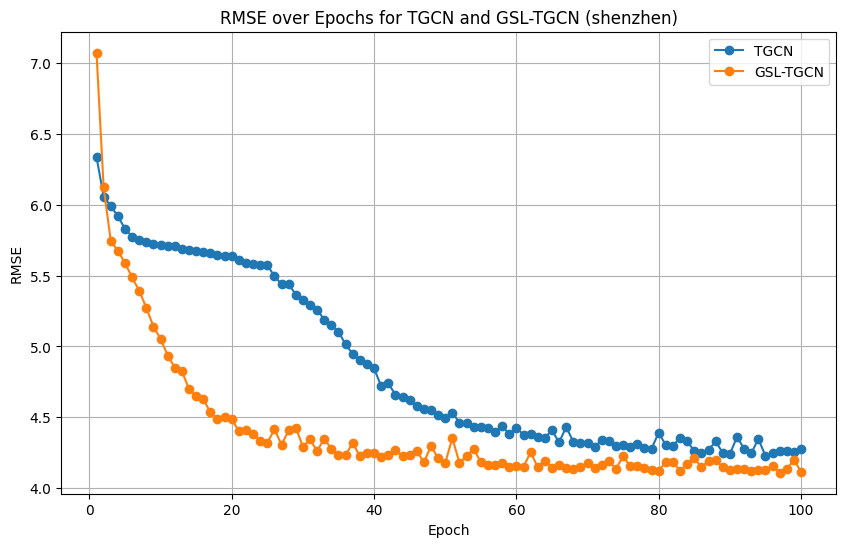

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics CSV files
metrics_file_gsl_false = "results/metrics_shenzhen_TGCN_seq12_pre1_gslFalse.csv"
metrics_file_gsl_true = "results/metrics_shenzhen_TGCN_seq12_pre1_gslTrue.csv"

metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

# Plot RMSE values
plt.figure(figsize=(10, 6))
plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false["RMSE"], marker='o', label="TGCN")
plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true["RMSE"], marker='o', label="GSL-TGCN")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs for TGCN and GSL-TGCN (shenzhen)")
plt.legend()
plt.grid(True)
plt.show()

Los

In [14]:
%%time
%run main.py --config configs/tgcn-los.yaml --log_path train-tgcn-los.log

[2025-02-27 11:40:33,493 INFO]Loaded config from configs/tgcn-los.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'losloop', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.TGCN', 'init_args': {'hidden_dim': 64, 'use_gsl': False}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse_with_regularizer'}}}
[2025-02-27 11:40:33,650 INFO]Using device: cuda
[2025-02-27 11:40:33,653 INFO]Starting training for 100 epochs...
[2025-02-27 11:40:34,633 INFO][Epoch 1/100] Train Loss: 2039.749698, Val Loss: 12150383.000000, RMSE: 17.327520, MAE: 14.101154, Accuracy: 0.7051, R2: 0.1995, Expl.Var: 0.3900
[2025-02-27 11:40:53,763 INFO][Epoch 21/100] Train Loss: 84.321248, Val Loss: 2729394.250000, RMSE: 8.212484, MAE: 5.764597, Accuracy: 0.8602, R2: 0.6485, Expl.Var: 0.6485
[2025-02-27 11:41:13,070 INFO][Epoch 41/100] Train Loss: 62.001329, Val Loss: 1989788.500000, RMSE: 7.012048, MAE: 4.880864, 

CPU times: total: 1min 27s
Wall time: 1min 36s


Los-GSL

In [15]:
%%time
%run main.py --config configs/tgcn-los-gsl.yaml --log_path train-tgcn-los-gsl.log

[2025-02-27 11:42:10,023 INFO]Loaded config from configs/tgcn-los-gsl.yaml: {'fit': {'trainer': {'max_epochs': 100, 'accelerator': 'cuda', 'devices': 1}, 'data': {'dataset_name': 'losloop', 'batch_size': 64, 'seq_len': 12, 'pre_len': 1}, 'model': {'model': {'class_path': 'models.TGCN', 'init_args': {'hidden_dim': 64, 'use_gsl': True}}, 'learning_rate': 0.001, 'weight_decay': 0, 'loss': 'mse_with_regularizer'}}}


[2025-02-27 11:42:10,129 INFO]Using device: cuda
[2025-02-27 11:42:10,136 INFO]Starting training for 100 epochs...
[2025-02-27 11:42:11,123 INFO][Epoch 1/100] Train Loss: 1649.418916, Val Loss: 27567994.000000, RMSE: 26.100212, MAE: 22.415703, Accuracy: 0.5558, R2: -1.4612, Expl.Var: -2.1077
[2025-02-27 11:42:30,165 INFO][Epoch 21/100] Train Loss: 49.259927, Val Loss: 1752282.250000, RMSE: 6.580266, MAE: 4.345520, Accuracy: 0.8880, R2: 0.7745, Expl.Var: 0.7749
[2025-02-27 11:42:49,150 INFO][Epoch 41/100] Train Loss: 37.401815, Val Loss: 1333204.000000, RMSE: 5.739707, MAE: 3.748990, Accuracy: 0.9023, R2: 0.8283, Expl.Var: 0.8285
[2025-02-27 11:43:07,962 INFO][Epoch 61/100] Train Loss: 33.409749, Val Loss: 1200022.375000, RMSE: 5.445479, MAE: 3.528592, Accuracy: 0.9073, R2: 0.8458, Expl.Var: 0.8478
[2025-02-27 11:43:26,839 INFO][Epoch 81/100] Train Loss: 30.538559, Val Loss: 1085758.250000, RMSE: 5.179740, MAE: 3.383784, Accuracy: 0.9118, R2: 0.8602, Expl.Var: 0.8602
[2025-02-27 11:43:4

CPU times: total: 1min 25s
Wall time: 1min 34s


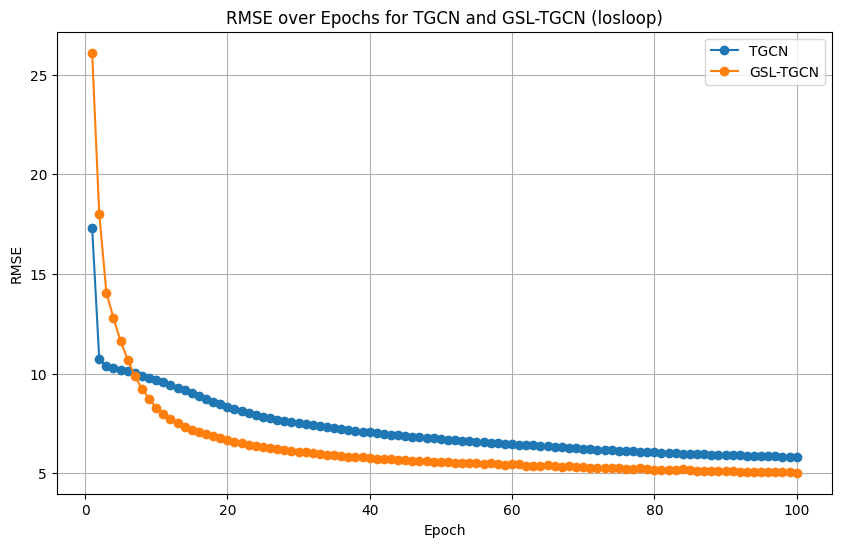

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics CSV files
metrics_file_gsl_false = "results/metrics_losloop_TGCN_seq12_pre1_gslFalse.csv"
metrics_file_gsl_true = "results/metrics_losloop_TGCN_seq12_pre1_gslTrue.csv"

metrics_df_gsl_false = pd.read_csv(metrics_file_gsl_false)
metrics_df_gsl_true = pd.read_csv(metrics_file_gsl_true)

# Plot RMSE values
plt.figure(figsize=(10, 6))
plt.plot(metrics_df_gsl_false["Epoch"], metrics_df_gsl_false["RMSE"], marker='o', label="TGCN")
plt.plot(metrics_df_gsl_true["Epoch"], metrics_df_gsl_true["RMSE"], marker='o', label="GSL-TGCN")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs for TGCN and GSL-TGCN (losloop)")
plt.legend()
plt.grid(True)
plt.show()